# Uncertainty Quantification based on Gaussian Reconstructions

The Gaussian reconstructions have 2.5 times the added noise to the k-space before reconstruction with vSHARP.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import scipy.ndimage
import glob
import os

from pathlib import Path
from typing import List, Tuple, Dict, Any, Tuple
from sqlite3 import connect
from pydicom import dcmread


####### PARAMETERS #######
VSHARP_READER_STUDY_ROOT = Path('/scratch/hb-pca-rad/projects/03_reader_set_v2')
LOGDIR = Path('logs/')

# vSHARP Reconstruction Root Directories
ACC_ROOTS = {
    3: Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    6: Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x")
}

# Location where the .h5 kspace files are stored for each patient
KSPACE_ROOT_DIR = Path('/scratch/p290820/datasets/003_umcg_pst_ksps')      # source_dir

# Databases 
DB_FPATH_OLD = Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db')               # References an OLDER version of the databases where the info could also just be fine that we are looking for
DB_FPATH_NEW = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db') # References the LATEST version of the databases where the info could also just be fine that we are looking for

# Parameters
DEBUG              = True
DO_TESTS           = True
ACC_FACTORS        = [1, 3, 6] # Define the set of acceleration factors we care about.
DO_NORM            = True      # RESCALE 01
DO_POST_PROCESSING = True      # Post-processing, for each sub-reconstruction, such as k-space interpolation, flipping, and cropping
SAVE_AS_NIFTI_SUBR = True      # Save each sub-reconstruction as a NIFTI file
DECIMALS           = 4         # Number of decimals to round to

# All patient IDs to consider for Uncertainty Quantification
PAT_IDS = [
    '0003_ANON5046358',
    # '0004_ANON9616598',
    # '0005_ANON8290811',
    # '0006_ANON2379607',
    # '0007_ANON1586301',
    # '0008_ANON8890538',
    # '0010_ANON7748752',
    # '0011_ANON1102778',
    # '0012_ANON4982869',
    # '0013_ANON7362087',
    # '0014_ANON3951049',
    # '0015_ANON9844606',
    # '0018_ANON9843837',
    # '0019_ANON7657657',
    # '0020_ANON1562419',
    # '0021_ANON4277586',
    # '0023_ANON6964611',
    # '0024_ANON7992094',
    # '0026_ANON3620419',
    # '0027_ANON9724912',
    # '0028_ANON3394777',
    # '0029_ANON7189994',
    # '0030_ANON3397001',
    # '0031_ANON9141039',
    # '0032_ANON7649583',
    # '0033_ANON9728185',
    # '0035_ANON3474225',
    # '0036_ANON0282755',
    # '0037_ANON0369080',
    # '0039_ANON0604912',
    # '0042_ANON9423619',
    # '0043_ANON7041133',
    # '0044_ANON8232550',
    # '0045_ANON2563804',
    # '0047_ANON3613611',
    # '0048_ANON6365688',
    # '0049_ANON9783006',
    # '0051_ANON1327674',
    # '0052_ANON9710044',
    # '0053_ANON5517301',
    # '0055_ANON3357872',
    # '0056_ANON2124757',
    # '0057_ANON1070291',
    # '0058_ANON9719981',
    # '0059_ANON7955208',
    # '0061_ANON7642254',
    # '0062_ANON0319974',
    # '0063_ANON9972960',
    # '0064_ANON0282398',
    # '0067_ANON0913099',
    # '0068_ANON7978458',
    # '0069_ANON9840567',
    # '0070_ANON5223499',
    # '0071_ANON9806291',
    # '0073_ANON5954143',
    # '0075_ANON5895496',
    # '0076_ANON3983890',
    # '0077_ANON8634437',
    # '0078_ANON6883869',
    # '0079_ANON8828023',
    # '0080_ANON4499321',
    # '0081_ANON9763928',
    # '0082_ANON6073234',
    # '0083_ANON9898497',
    # '0084_ANON6141178',
    # '0085_ANON4535412',
    # '0086_ANON8511628',
    # '0087_ANON9534873',
    # '0088_ANON9892116',
    # '0089_ANON9786899',
    # '0090_ANON0891692',
    # '0092_ANON9941969',
    # '0093_ANON9728761',
    # '0094_ANON8024204',
    # '0095_ANON4189062',
    # '0097_ANON5642073',
    # '0103_ANON8583296',
    # '0104_ANON7748630',
    # '0105_ANON9883201',
    # '0107_ANON4035085',
    # '0108_ANON0424679',
    # '0109_ANON9816976',
    # '0110_ANON8266491',
    # '0111_ANON9310466',
    # '0112_ANON3210850',
    # '0113_ANON9665113',
    # '0115_ANON0400743',
    # '0116_ANON9223478',
    # '0118_ANON7141024',
    # '0119_ANON3865800',
    # '0120_ANON7275574',
    # '0121_ANON9629161',
    # '0123_ANON7265874',
    # '0124_ANON8610762',
    # '0125_ANON0272089',
    # '0126_ANON4747182',
    # '0127_ANON8023509',
    # '0128_ANON8627051',
    # '0129_ANON5344332',
    # '0135_ANON9879440',
    # '0136_ANON8096961',
    # '0137_ANON8035619',
    # '0138_ANON1747790',
    # '0139_ANON2666319',
    # '0140_ANON0899488',
    # '0141_ANON8018038',
    # '0142_ANON7090827',
    # '0143_ANON9752849',
    # '0144_ANON2255419',
    # '0145_ANON0335209',
    # '0146_ANON7414571',
    # '0148_ANON9604223',
    # '0149_ANON4712664',
    # '0150_ANON5824292',
    # '0152_ANON2411221',
    # '0153_ANON5958718',
    # '0155_ANON7828652',
    # '0157_ANON9873056',
    # '0159_ANON9720717',
    # '0160_ANON3504149'
]


### Logging


In [ ]:
import logging
from datetime import datetime

def setup_logger(log_dir: Path, use_time: bool = True, part_fname: str = None) -> logging.Logger:
    """
    Configure logging to both console and file.
    This function sets up logging based on the specified logging directory.
    It creates a log file named with the current timestamp and directs log 
    messages to both the console and the log file.
    Parameters:
    - log_dir (Path): Directory where the log file will be stored.
    Returns:
    - logging.Logger: Configured logger instance.
    """
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    if use_time: 
        log_file = log_dir / f"log_{current_time}.log"
    elif part_fname is not None and use_time: 
        log_file = log_dir / f"log_{part_fname}_{current_time}.log"
    elif part_fname is not None and not use_time:
        log_file = log_dir / f"log_{part_fname}.log"
    else:
        log_file = log_dir / "log.log"

    l = logging.getLogger()
    l.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    l.addHandler(file_handler)

    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    l.addHandler(console_handler)

    return l

LOGGER = setup_logger(LOGDIR, use_time=False, part_fname='post_process_inference')

### Function for Finding image space shape of the dicoms

In [ ]:
def get_shapes_from_dicom(dicom_dir: Path) -> Tuple:
    """Get the zero-pad shape and image space crop shape from the first dicom file in the directory."""

    # We'll be working with str instead of Path
    dicom_dir = str(dicom_dir)

    assert os.path.isdir(dicom_dir), f"dicom_dir must be a directory, got: {dicom_dir}"

    pattern = os.path.join(dicom_dir, '*')
    print(f"\tLooking for dicom files in pattern: {pattern}")

    dcm_fpaths = glob.glob(pattern)
    print(f"\tNumber of detected dicom files in: {len(dcm_fpaths)}")

    first_slice_fpath = dcm_fpaths[0]

    ds = dcmread(first_slice_fpath)

    zero_pad_shape = (ds.Rows*2, ds.Columns*2)
    image_space_crop = (ds.Rows, ds.Columns)
    print(f"\tCalculated ZERO-PAD shape: {zero_pad_shape}, based on rows, cols of the DICOM: {image_space_crop}")

    return zero_pad_shape, image_space_crop


def find_t2_tra_dir_in_study_dir(study_dir: Path) -> Path:
    """
    Description: Find the T2 TSE TRA directory in the study directory.
    Args:
        study_dir (Path): The study directory.
    Returns:
        Path: The T2 TSE TRA directory.
    """
    for seq_dir in study_dir.iterdir():
        if "tse2d1" in seq_dir.name.lower():  # Using lower() for case-insensitive match
            # List the files in the seq_dir and take the first and read with pydicom
            dcm_files = list(seq_dir.glob('*'))
            if dcm_files:  # Ensure there's at least one file to read
                dcm = dcmread(dcm_files[0])
                # If ProtocolName contains T2, TSE, and TRA, case insensitive, then we return the directory
                protocol_name = dcm.ProtocolName.lower()  # Make comparison case-insensitive
                if "t2" in protocol_name and "tse" in protocol_name and "tra" in protocol_name:
                    return seq_dir  # Returning the directory, not the DICOM object
    return None  # Return None if no matching directory is found


def find_respective_dicom_dir(pat_id: str, source_dir: Path = None, db_fpath: Path = None) -> Tuple[Path, Path]:
    """
    Description: Find the respective DICOM directory for the given patient ID based on the kspace acquisition date.
    Args:
        pat_id (str): The patient ID.
        source_dir (Path): The source directory where the data is stored.
        db_fpath (Path): The path to the database file.
    Returns:
        Tuple[Path, Path]: The DICOM directory and the NIFTI directory.
    """
    
    anon_id = pat_id.split('_')[-1]
    print(f"Db patient ID: {anon_id}")
    
    conn = connect(str(db_fpath))
    cursor = conn.cursor()
    try:
        # Query to retrieve all MRI dates for the given patient ID
        query = "SELECT mri_date FROM kspace_dset_info WHERE anon_id = ? ORDER BY mri_date"
        cursor.execute(query, (anon_id,))
        results = cursor.fetchall()
        print(f"\tResults from the query: {results}")
                
        if results:
            for result in results:        # loops over each study date found in the database and checks if it there is a matching dicom directory
                mri_date = str(result[0]) 
                mri_date_str = "{}-{}-{}".format(mri_date[:4], mri_date[4:6], mri_date[6:]) # Convert YYYY-MM-DD
                study_dir_path_dcms = source_dir / 'data' / pat_id / 'dicoms' / mri_date_str  # Construct expected DICOM dir path
                study_dir_path_niftis = source_dir / 'data' / pat_id / 'niftis' / mri_date_str  # Construct expected NIFTI dir path
                print(f"\tChecking for study dir: {study_dir_path_dcms}")
                print(f"\tChecking for study dir: {study_dir_path_niftis}")
                
                if study_dir_path_dcms.exists() and study_dir_path_niftis.exists():
                    print(f"\t\tMatching dicom dir found for patient ID based on kspace acquisition date {pat_id} in {source_dir / 'data' / pat_id / 'dicoms'}")
                    print(f"\t\tMatching nifti dir found for patient ID based on kspace acquisition date {pat_id} in {source_dir / 'data' / pat_id / 'niftis'}")
                    t2_tra_dcm_dir = find_t2_tra_dir_in_study_dir(study_dir_path_dcms)

                    # We have found the correct dicom link that immediatly to the to correct nifti and return that file too.
                    t2_tra_nif_fpath = Path(str(t2_tra_dcm_dir).replace('dicoms', 'niftis') + '.nii.gz')
                    
                    return t2_tra_dcm_dir, t2_tra_nif_fpath
                else:
                    print(f"\tWarning: No matching study directory found for patient ID {pat_id} in {source_dir / 'data' / pat_id / 'dicoms'}")
                
            # If no matching directory is found after checking all dates
            print(f"\tWarning: No matching study directory found for patient ID {pat_id}")
            raise Exception(f"No matching study directory found for patient ID {pat_id} in {source_dir / 'data' / pat_id / 'dicoms'}")
        else:
            print(f"\tWarning: No MRI date found for patient ID {pat_id}")
            raise Exception(f"No MRI date found for patient ID {pat_id}")
    finally:
        conn.close()

## Only load all the reconstructions, then we process them after loading

In [ ]:
def center_crop_3d(image_3d: np.ndarray, target_shape: Tuple[int, int, int], debug: bool = False) -> np.ndarray:
    """
    Center-crop a 3D volume back to a specified shape.

    Args:
        image_3d (np.ndarray): 3D array (slices, rows, columns).
        target_shape (Tuple[int, int, int]): Desired (slices, rows, columns).

    Returns:
        np.ndarray: Cropped 3D array of shape target_shape.
    """
    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert len(target_shape) == 3, "target_shape must be a 3-element tuple"
    slices, rows, cols = image_3d.shape
    t_slices, t_rows, t_cols = target_shape

    # For simplicity, we only crop rows/cols and assume the slice dimension is the same
    assert slices == t_slices, "We only center-crop rows & columns here; slice dim must match."
    row_start = (rows - t_rows) // 2
    col_start = (cols - t_cols) // 2

    print(f"Center-cropping image from {image_3d.shape} to {target_shape}") if debug else None

    return image_3d[:, row_start:row_start+t_rows, col_start:col_start+t_cols]


def zero_pad_in_sim_kspace(
    image_3d: np.ndarray, 
    desired_shape: Tuple[int, int] = (1280, 1280),
) -> np.ndarray:
    """
    Zero pad a 3D image array in the simulated k-space.
    
    Parameters:
    - input_image: 3D ndarray, the image to be zero-padded
    - desired_shape: tuple, the desired shape after zero-padding
    - verbose: boolean, whether to print additional information
    
    Returns:
    - 3D ndarray, the zero-padded image
    """
    assert image_3d.dtype == np.float32, "Expecting the input image to be of type float32."
    assert image_3d.shape[0] < image_3d.shape[1] and image_3d.shape[0] < image_3d.shape[2], "Expecting the first dim to be the slice dim."
    assert len(image_3d.shape) == 3, "Expecting 3D array."
    print(f"\tShape of the input image before zero-padding: {image_3d.shape}, with dtype {image_3d.dtype}")

    n_slices, width, height = image_3d.shape
    padded_image = np.zeros((n_slices, *desired_shape), dtype=image_3d.dtype)

    pad_width = desired_shape[0] - width
    pad_height = desired_shape[1] - height
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    for i in range(n_slices):
        img_slice            = image_3d[i, ...]
        kspace_slice         = np.fft.fft2(img_slice)
        kspace_slice_shift1  = np.fft.fftshift(kspace_slice)
        kspace_slice_padded  = np.pad(kspace_slice_shift1, ((pad_left, pad_right), (pad_top, pad_bottom)), mode='constant', constant_values=0)
        kspace_slice_shift2  = np.fft.ifftshift(kspace_slice_padded)
        img_slice_padded     = np.fft.ifft2(kspace_slice_shift2)
        padded_image[i, ...] = np.abs(img_slice_padded)

        print(f"\t\tSlice {i+1}/{n_slices} done.")
        print(f"\t\t\tShape of the kspace_slice: {kspace_slice.shape}, with dtype {kspace_slice.dtype}")
        print(f"\t\t\tShape of the kspace_slice_padded: {kspace_slice_padded.shape}, with dtype {kspace_slice_padded.dtype}")
        print(f"\t\t\tShape of the img_slice_padded: {img_slice_padded.shape}, with dtype {img_slice_padded.dtype}")
        print(f"\t\t\tShape of the padded_image: {padded_image.shape}, with dtype {padded_image.dtype}")

    return padded_image


def center_crop(
    image: np.ndarray,
    crop_shape: Tuple[int, int]
) -> np.ndarray:
    """
    Perform a center crop on a 2D or 3D numpy array.
    
    Args:
    - arr (np.ndarray): The array to be cropped. Could be either 2D or 3D.
    - crop_shape (Tuple[int, int]): Desired output shape (height, width).
    
    Returns:
    - np.ndarray: Center cropped array.
    """
    assert len(image.shape) in [2, 3], f"Invalid number of dimensions. Expected 2D or 3D array, got shape {image.shape}."
    assert len(crop_shape) == 2, f"Invalid crop_shape dimension. Expected a tuple of length 2, got {crop_shape}."

    # Original shape and crop shape 
    original_shape = image.shape[-2:]
    crop_height, crop_width = crop_shape
    
    # Padding dimensions 
    pad_height = original_shape[0] - crop_height
    pad_width = original_shape[1] - crop_width
    
    if pad_height < 0 or pad_width < 0:
        raise ValueError(f"Crop shape {crop_shape} larger than the original shape {original_shape}.")
        
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Perform the crop
    if len(image.shape) == 3:
        cropped_arr = image[:, pad_top:-pad_bottom, pad_left:-pad_right]
    else:
        cropped_arr = image[pad_top:-pad_bottom, pad_left:-pad_right]
    print(f"\tCenter crop: Original shape: {original_shape}, crop shape: {crop_shape}, pad: {pad_top, pad_bottom, pad_left, pad_right}, cropped shape: {cropped_arr.shape}")
        
    return cropped_arr


def norm_rescale01(recon: np.ndarray, debug: bool = False) -> np.ndarray:
    """
    Normalize and rescale the reconstructions to [0, 1].
    
    Args:
        recon (np.ndarray): 3D NumPy array with shape (slices, rows, cols).
    
    Returns:
        np.ndarray: Normalized and rescaled 3D NumPy array.
    """
    assert isinstance(recon, np.ndarray), "recon must be a NumPy array."

    if debug:
        print(f"Applying normalization rescale01 to reconstructions with shape: {recon.shape}")

    # Add a small epsilon to avoid division by zero.
    return (recon - recon.min()) / (recon.max() - recon.min() + 1e-8)


def post_process_3d_image(
    image_3d: np.ndarray,
    zero_pad_shape: Tuple,
    image_space_crop: Tuple
) -> np.ndarray:
    """
    Apply the image processing steps to make the input image look like a dicom image.
    Args:
        image_3d (np.ndarray): The input 3D reconstruction.
        zero_pad_shape (Tuple): The desired shape after zero-padding.
        image_space_crop (Tuple): The desired shape after cropping.
    Returns:
        np.ndarray: The post-processed (dicom-like) reconstruction.
    """

    # Step 1: Flip both the width and height of the image, the RIM output relative to the dicom is flipped
    post_image_3d = np.flip(image_3d, axis=(0,1,2))
    print(f"\tFlipped width and height with axis=(0,1,2)")

    # Step 2: Zero-pad simulated kspace to the desired shape and get the image back from the padded kspace
    post_image_3d = zero_pad_in_sim_kspace(image_3d=post_image_3d, desired_shape=zero_pad_shape)

    # Step 3: Take a center crop of the image space
    post_image_3d = center_crop(post_image_3d, crop_shape=image_space_crop)

    return post_image_3d


def load_patient_reconstructions(
        pat_root: Path  = None,
        norm            = False,
        do_post_process = True,
        acceleration    = None,
        save_nifti      = False,
        ref_nifti       = None,
        debug           = False
    ) -> np.ndarray:
    """
    Load and process the reconstructions for a patient directory containing .h5 files.
    it will load the reconstructions, normalize them to [0, 1], apply post-processing, and save them as Nifti files.
    There will be multiple reconstructions for each patient, depending on the number of .h5 files.
    
    Args:
        pat_root (Path): Path to the patient directory containing .h5 files.
        norm (bool): Normalize the reconstructions to [0, 1].
        do_post_process (bool): Apply post-processing to the reconstructions.
        acceleration (int): Acceleration factor (3 or 6) for post-processing.
        save_nifti (bool): Save the reconstructions as Nifti files.
        ref_nifti (np.ndarray): Reference Nifti copying of image infomation to make the reconstructions in the same spacing as the reference.
        debug (bool): Print debug information.
    
    Returns:
        np.ndarray: 4D NumPy array with shape (num_files, slices, rows, cols).
    """
    if DO_TESTS:
        assert pat_root.is_dir(), f"pat_root must be a directory, got: {pat_root}"
        assert isinstance(norm, bool), "norm must be a boolean."
        assert isinstance(do_post_process, bool), "do_post_process must be a boolean."
        assert acceleration in [3, 6], "acceleration must be None, 3, or 6."
        assert isinstance(debug, bool), "debug must be a boolean."
        assert isinstance(save_nifti, bool), "save_nifti must be a boolean."
        assert ref_nifti is None or isinstance(ref_nifti, sitk.Image), "ref_nifti must be None or a SimpleITK image."
        assert not save_nifti or ref_nifti is not None, "save_nifti and ref_nifti must be true toghether."

    h5_files = list(pat_root.glob('*.h5'))
    print(f"\nProcessing patient directory: {pat_root}, Found {len(h5_files)} .h5 files") if debug else None

    pat_id = pat_root.name
    dicom_dir, _ = find_respective_dicom_dir(pat_id, KSPACE_ROOT_DIR, DB_FPATH_OLD)
    zero_pad_shape, image_space_crop = get_shapes_from_dicom(dicom_dir)

    recons = []
    for idx, gaus_h5_file in enumerate(h5_files):
        print(f'\nProcessing: {gaus_h5_file.name}, with gaussian_id: {str(gaus_h5_file.stem).split("_")[-1]} ({idx+1}/{len(h5_files)})')
        
        with h5py.File(gaus_h5_file, 'r') as f:

            # 1) Loading
            recon_np = f['reconstruction'][()]
            # 2) Normalization
            if norm:
                recon_np = norm_rescale01(recon_np, debug=debug)
            # 3) Post-processing
            if do_post_process:
                recon_np = post_process_3d_image(recon_np, zero_pad_shape, image_space_crop)
            # 4) Save Nifti
            if save_nifti and ref_nifti is not None:
                recon_sitk = sitk.GetImageFromArray(recon_np)
                recon_sitk.CopyInformation(ref_nifti)
                dcml = "dcml" if do_post_process else ""
                recon_nifti_path = gaus_h5_file.parent / f"vsharp_r6_recon_{dcml}_{str(gaus_h5_file.stem).split('_')[-1]}.nii.gz"
                sitk.WriteImage(recon_sitk, str(recon_nifti_path))
                print(f"Saved reconstruction to: {recon_nifti_path}")
            if debug:
                print(f"Shape: {recon_np.shape}, Max: {recon_np.max():.7f}, Min: {recon_np.min():.7f}, Mean: {recon_np.mean():.7f}, Std: {recon_np.std():.7f}")
            recons.append(recon_np)

    recons_4d = np.stack(recons)
    print(f"Shape of recons_4d: {recons_4d.shape}") if debug else None
    return recons_4d




################################ Main ################################


################################ Data Structures ################################
# We'll store single reconstructions in one dictionary and stacks in another.
# Key = acceleration factor, Value = list of 3D or 4D arrays (one per patient).
single_recons_dict = {1: [], 3: [], 6: []}
stack_recons_dict = {3: [], 6: []}  # R=1 doesn't have a stack of reconstructions.

# Loop over each patient and each acceleration factor
for pat_id in PAT_IDS:
    for acc in ACC_FACTORS:
        print(f"\nLoading reconstructions for patient: {pat_id}, Acceleration: {acc}")

        if acc == 1:
            # R=1: load the single reference reconstruction (e.g., _rss_target_dcml.mha)
            r1_fname = VSHARP_READER_STUDY_ROOT / pat_id / f"{pat_id}_rss_target_dcml.mha"
            recon_r1_sitk = sitk.ReadImage(str(r1_fname))
            recon_r1_arr = sitk.GetArrayFromImage(recon_r1_sitk)
            single_recons_dict[1].append(recon_r1_arr)
        
        else:
            # R=3 or R=6: load the single recon AND the stack of reconstructions
            recon_fname = VSHARP_READER_STUDY_ROOT / pat_id / f"{pat_id}_VSharp_R{acc}_recon_dcml.mha"
            recon_sitk = sitk.ReadImage(str(recon_fname))
            recon_arr = sitk.GetArrayFromImage(recon_sitk)
            single_recons_dict[acc].append(recon_arr)
            
            # Load the stack (multiple reconstructions for uncertainty quantification)
            # Use your load_patient_reconstructions function
            # For R=3 or R=6, we map them to ACC_ROOTS[acc].
            recon_stack_4d = load_patient_reconstructions(
                pat_root        = ACC_ROOTS[acc] / pat_id,
                norm            = DO_NORM,
                do_post_process = DO_POST_PROCESSING,
                acceleration    = acc,
                save_nifti      = SAVE_AS_NIFTI_SUBR,
                ref_nifti       = recon_sitk,   # optional reference SITK image
                debug           = DEBUG
            )
            stack_recons_dict[acc].append(recon_stack_4d)

print("\nDone loading reconstructions.")
print("Single Recon Shapes:")
for acc in single_recons_dict:
    print(f"  R={acc}: {len(single_recons_dict[acc])} items loaded.")

print("Stack Recon Shapes (for R=3, R=6):")
for acc in [3, 6]:
    print(f"  R={acc}: {len(stack_recons_dict[acc])} stacks loaded.")


Loading reconstructions for patient: 0003_ANON5046358, Acceleration: 1

Loading reconstructions for patient: 0003_ANON5046358, Acceleration: 3

Processing patient directory: /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_3x/0003_ANON5046358, Found 13 .h5 files
Db patient ID: ANON5046358
	Results from the query: [(20220510,)]
	Checking for study dir: /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/dicoms/2022-05-10
	Checking for study dir: /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/niftis/2022-05-10
		Matching dicom dir found for patient ID based on kspace acquisition date 0003_ANON5046358 in /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/dicoms
		Matching nifti dir found for patient ID based on kspace acquisition date 0003_ANON5046358 in /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/niftis
	Looking for dicom files in pattern: /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003

# Actual Uncertainty Quantification with STD and visualization

We also apply a percentile tresholding to view uncertain parts. I dont know if 95% makes sense, but we go with it for now.

Selected Patient: 0003_ANON5046358, Acceleration: 6, on slice: 15
Patient Directory: /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358
Shape of uncertainty map: (30, 768, 768)
Min max of the uncertainty map (rounded): 9.999999747378752e-05 - 0.0044999998062849045
Rounding uncertainty map to 4 decimals


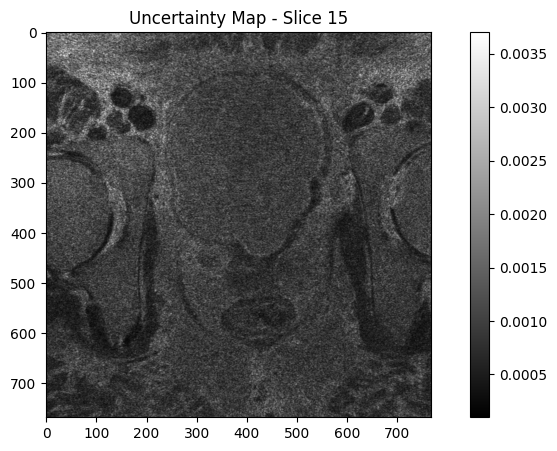

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map.nii.gz
Applying percentile threshold: 99%
Threshold value: 0.002115321811288595
Rounding uncertainty map to 4 decimals


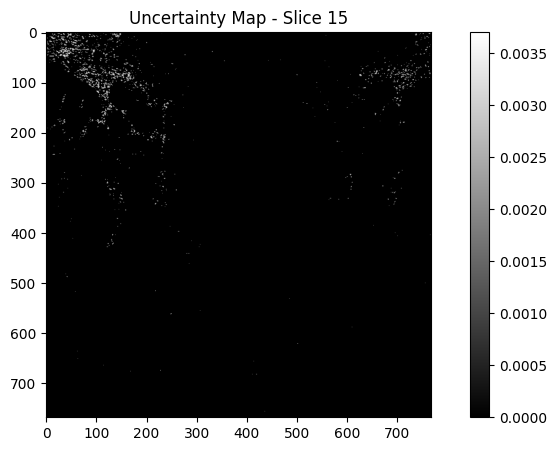

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map_th99.nii.gz
Applying percentile threshold: 95%
Threshold value: 0.0016534160822629929
Rounding uncertainty map to 4 decimals


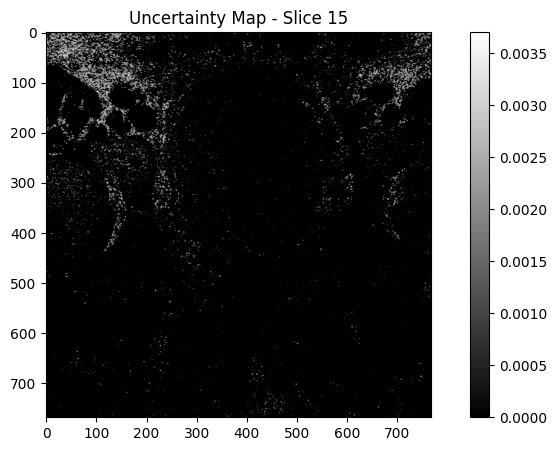

Saved uncertainty map as /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_6x/0003_ANON5046358/uq_map_th95.nii.gz


In [ ]:
def calculate_uncertainty_map(reconstructions: np.ndarray, debug=False) -> np.ndarray:
    """
    Calculate the uncertainty map by computing the standard deviation across reconstructions.
    
    Args:
        reconstructions (np.ndarray): 4D NumPy array with shape (num_reconstructions, slices, rows, cols).
    
    Returns:
        np.ndarray: 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
    """
    assert isinstance(reconstructions, np.ndarray), "reconstructions must be a NumPy array."
    assert reconstructions.ndim == 4, f"Expected 4D array, got {reconstructions.ndim}D array."
    
    uq_map = reconstructions.std(axis=0)
    if debug: 
        print(f"Shape of uncertainty map: {uq_map.shape}")
        print(f"Min max of the uncertainty map (rounded): {np.round(uq_map.min(), 4)} - {np.round(uq_map.max(), 4)}")
    return uq_map


def visualize_uncertainty_map(uq_map: np.ndarray, slice_idx: int = 0, save_path: Path = None, do_round = False, decimals = 3):
    """
    Visualize the uncertainty map and optionally save it as a NIfTI file.
    
    Args:
        uq_map (np.ndarray): 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
        slice_idx (int): Index of the slice to visualize.
        save_path (Path): Path to save the uncertainty map as a NIfTI file. If None, the map is not saved.
    """
    assert isinstance(uq_map, np.ndarray), "uq_map must be a NumPy array."
    assert uq_map.ndim == 3, f"Expected 3D array, got {uq_map.ndim}D array."
    assert 0 <= slice_idx < uq_map.shape[0], f"slice_idx out of range (0 to {uq_map.shape[0]-1})"
    
    # if the data is nicely between 0 and 1, we can use the 'gray' colormap and we can round 
    if do_round:
        print(f'Rounding uncertainty map to {decimals} decimals')
        uq_map = np.round(uq_map, decimals)

    # Plotting
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(uq_map[slice_idx], cmap='gray')
    plt.colorbar()
    plt.title(f'Uncertainty Map - Slice {slice_idx}')
    plt.show()
    
    # Save as NIfTI file if save_path is provided
    if save_path:
        uq_map_sitk = sitk.GetImageFromArray(uq_map)
        sitk.WriteImage(uq_map_sitk, str(save_path))
        print(f'Saved uncertainty map as {save_path}')


def apply_percentile_threshold(uq_map: np.ndarray, percentile: float = 95.0, debug=False) -> np.ndarray:
    """
    Apply a percentile threshold to the uncertainty map, keeping only the top percentile values.
    
    Args:
        uq_map (np.ndarray): 3D NumPy array representing the uncertainty map with shape (slices, rows, cols).
        percentile (float): Percentile threshold to apply. Default is 95.0.
    
    Returns:
        np.ndarray: Thresholded uncertainty map with the same shape as input.
    """
    assert isinstance(uq_map, np.ndarray), "uq_map must be a NumPy array."
    assert uq_map.ndim == 3, f"Expected 3D array, got {uq_map.ndim}D array."
    
    threshold_value = np.percentile(uq_map, percentile)
    if debug:
        print(f"Applying percentile threshold: {percentile}%")
        print(f"Threshold value: {threshold_value}")
    
    thresholded_uq_map = np.where(uq_map >= threshold_value, uq_map, 0)
    return thresholded_uq_map




######################################## Main ########################################
# Visualization Parameters
pat_idx = 0         # Index of the patient to visualize
acc_vis = 6         # Acceleration factor to visualize
slice_idx = 15      # Slice index for visualization
thresholds = [99, 95]  # Percentile thresholds for uncertainty maps

# Get the reconstructions for the selected patient and acceleration factor
pat_gaus_recons = stack_recons_dict[acc_vis][pat_idx]  # Select patient reconstructions
assert pat_gaus_recons.ndim == 4, f"Expected 4D array, got {pat_gaus_recons.ndim}D array."

# Define patient directory
pat_dir = ACC_ROOTS[acc_vis] / PAT_IDS[pat_idx]

# Nice print statement: for all variables assigned
print(f"Selected Patient: {PAT_IDS[pat_idx]}, Acceleration: {acc_vis}, on slice: {slice_idx}")
print(f"Patient Directory: {pat_dir}")


# Calculate and visualize the uncertainty map
uq_map = calculate_uncertainty_map(pat_gaus_recons, debug=True)
visualize_uncertainty_map(
    uq_map, 
    slice_idx  = slice_idx, 
    save_path  = pat_dir / 'uq_map_gm25.nii.gz', 
    do_round   = True, 
    decimals   = DECIMALS
)

# Apply percentile thresholds and visualize
for threshold in thresholds:
    uq_map_th = apply_percentile_threshold(uq_map, percentile=threshold, debug=True)
    visualize_uncertainty_map(
        uq_map_th, 
        slice_idx = slice_idx, 
        save_path = pat_dir / f'uq_map_th{threshold}.nii.gz', 
        do_round  = True, 
        decimals  = DECIMALS
)